# Project Overview


## 1. Import Python Packages

In [1]:
import keras_preprocessing
from keras_preprocessing import image
import tensorflow as tf
from tensorflow import keras 
import natsort
from natsort import natsorted
from glob import glob
from skimage import img_as_float32
import imageio
from functools import partial
from tqdm import tqdm
tqdm = partial(tqdm, position=0, leave=True)
import cv2 as cv
import numpy as np
import os
import matplotlib.pyplot as plt

# new implementation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout
from tensorflow.keras.optimizers  import Adam
from keras_applications.vgg16 import VGG16
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

### 1.1 Initialize Constant Values

In [2]:
# initialize constant variables
IMAGE_CHANNELS = 3
MASKS_CHANNELS = 1
COLUMNS = 4
ROWS = 3

# get training images corressponding masks
TRAIN_DATA_PATH = list(zip(
    natsorted(glob(f'./dataset/train/*.png')),
    natsorted(glob(f'./dataset/train_labels/*.png')),
))

# get validation images and corresponding masks
VAL_DATA_PATH = list(zip(
    natsorted(glob(f'./dataset/val/*.png')),
    natsorted(glob(f'./dataset/val_labels/*.png')),
))

# get test images and corresponding masks
TEST_DATA_PATH= list(zip(
    natsorted(glob(f'./dataset/test/*.png')),
    natsorted(glob(f'./dataset/test_labels/*.png')),
))

## 2. Image Preprocessing

In [3]:
class ImagePreProcessing(object):
    """
    This is a blueprint for image processing
    """
    
    def __init__(self, IMAGES = None, MASKS = None):
        """
        This method initiates the constructor which assigns values to data members of the class when aan  object is created
        """
        self.SIZE = (512,512)
        self.IMAGES = []
        self.MASKS = []
        
    def get_images(self, PATH):
        """
        This method loads and converts images as a color image
        :returns: images as numpy array
        """
        
        # read all images and store them in an array. 
        # borrowed from https://realpython.com/storing-images-in-python/
        for img_path, _ in tqdm(PATH, "Loading images"):
            
            # load images as float32 and store it in an array
            image = img_as_float32(cv.imread(img_path, cv.IMREAD_COLOR))
            
            # downsample the input image to 512 x 512 x 3
            image = cv.resize(image, self.SIZE)
            
            # convert images to color images since opencv reads images grayscale
            image = cv.cvtColor(image, cv.COLOR_BGR2RGB)
            
            # store all images
            self.IMAGES.append(image)
            
        # convert image to a numpy array
        IMGS = np.array(self.IMAGES)
        
        # check if all images have the same size and color images (RGB with 3 channels)
        assert IMGS.shape == (len(self.IMAGES), self.SIZE[0], self.SIZE[1], IMAGE_CHANNELS)
   
        return IMGS
            
            
    def get_masks(self, PATH):
        """
        This method loads and converts images as a grayscale image
        :returns: masks as a numpy array      
        """
        
        # read all images and store them in an array. 
        # borrowed from https://realpython.com/storing-images-in-python/
        for _, msk_path  in tqdm(PATH, "Loading masks"):
            
            # load images as float32 and store it in an array
            mask = img_as_float32(cv.imread(msk_path, cv.IMREAD_COLOR))
            
            # downsample the input image to 512 x 512 
            mask= cv.resize(mask, self.SIZE)
            
            # convert masks to grayscale 
            mask = cv.cvtColor(mask, cv.COLOR_BGR2GRAY)
            
            # store all masks
            self.MASKS.append(mask)
            
        # convert masks to a numpy array
        MSKS = np.array(self.MASKS)
        
        # expand the dimensions of the masks
        MSKS = np.expand_dims(MSKS, axis=3)
        
        # check if all masks have the same size
        assert MSKS.shape == (len(self.MASKS), self.SIZE[0], self.SIZE[1], MASKS_CHANNELS)
                
        return MSKS
    
    def get_dimensions(self):
        """
        This method gets dimensions of both the images and masks after downsampling
        :return: images and masks dimensions
        """     
    
        print("\n", "(1400, 1400, 3) ","=>", self.IMAGES[0].shape)
        print('\n', "1400, 1400) ", "=>", self.MASKS[0].shape)

In [4]:
# get imagepreprocessing object
buildings_segmentation =  ImagePreProcessing()

In [5]:
# loads train images
train_images = buildings_segmentation.get_images(TRAIN_DATA_PATH)

Loading images: 100%|██████████| 131/131 [00:10<00:00, 12.58it/s]


In [6]:
# loads traing masks
train_masks = buildings_segmentation.get_masks(TRAIN_DATA_PATH)

Loading masks: 100%|██████████| 131/131 [00:04<00:00, 31.14it/s]


In [7]:
# loads validation images
validation_images = buildings_segmentation.get_images(VAL_DATA_PATH)

Loading images: 100%|██████████| 10/10 [00:00<00:00, 12.68it/s]


In [8]:
# load validation masks
validation_masks = buildings_segmentation.get_masks(VAL_DATA_PATH)

Loading masks: 100%|██████████| 10/10 [00:00<00:00, 25.59it/s]


In [9]:
# get the original and downsampled images and masks dimensions
buildings_segmentation.get_dimensions()


 (1400, 1400, 3)  => (512, 512, 3)

 1400, 1400)  => (512, 512)


## 3. Generate Visualization/Plots

In [25]:
class ImageVisualization(object):
    """
    This is a blueprint for visualizing images and plots.
    """
    def __init__(self):
        pass

    def get_image_visualization(self, images, masks):
        """
        This method visualizes images and corresponding masks.
        :returns: images and masks plots
        """
        
        # iterate ovver the images and masks
        for image in range(3):
            
            # set grid or placeholder for images and masks
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (14, 14))
            
            # set the title of the images
            ax1.set_title('Original Image')
            
            # get the images
            ax1.imshow(images[image])
            ax1.axis("off")
            # set the masks title
            ax2.set_title('Corresponding Mask')
            
            # show corresponding masks
            ax2.imshow(np.squeeze(masks[image]), cmap="gray")
            ax2.axis("off")
           
            # visualize images and masks
            plt.show()

In [26]:
# instantiates image visualization object
visuals = ImageVisualization()

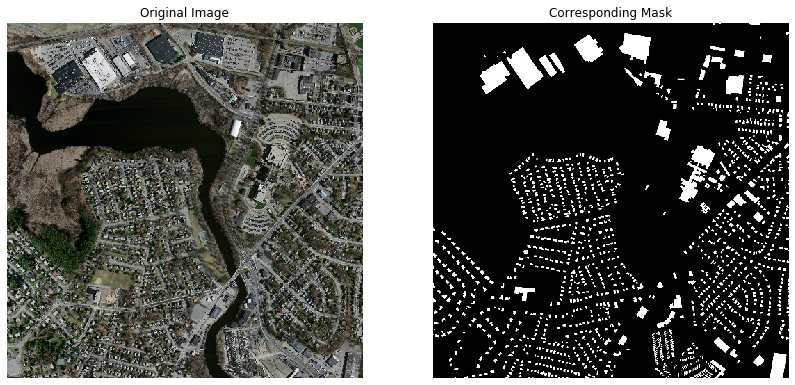

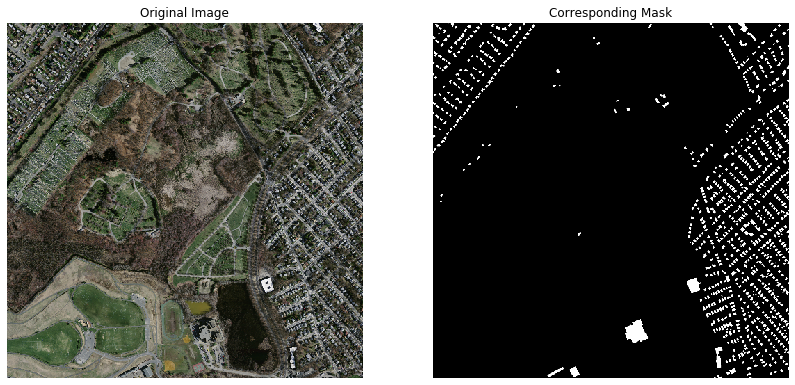

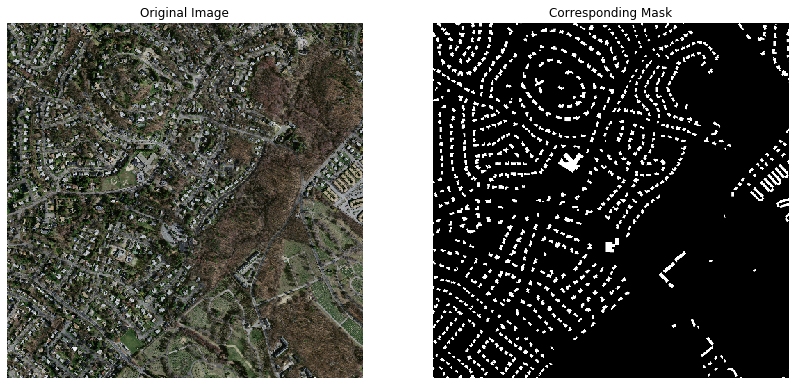

In [27]:
# visualize images and masks
image_masks_visuals = visuals.get_image_visualization(train_images, train_masks)

## 4. Apply Data Augmentation

In [28]:
class DataAugmentation(object):
    """
    This is a blueprint for augmenting images
    """
    def __init__(self):
        pass

## 5. Train The Model 

In [ ]:
class UnetImplementation(object):
    """
    This is a blueprint for unets implementation
    """
    def __init__(self):
        pass
    
    def get_conv2D_block(self):
        
        x = Con
        

In [ ]:
def conv2d_block( input_tensor, n_filters, kernel_size = (3,3)):
    "Add 2 conv layer"
    x = Conv2D(filters=n_filters, kernel_size=kernel_size, kernel_initializer='he_normal', 
             padding='same',activation="relu")(input_tensor)

    x = Conv2D(filters=n_filters, kernel_size=kernel_size, kernel_initializer='he_normal', 
             padding='same',activation="relu")(x)
    return x

def unet_implementation(img_dimensions):
    
    vgg = VGG16(weights='imagenet',include_top=False, input_shape=img_dimensions)
    vgg.layers.pop()
    vgg.trainable=False
    for layer in vgg.layers[:-4]:
        layer.trainable = False

    u1 = Conv2DTranspose(512, (3, 3), strides = (2, 2), padding = 'same')(vgg.get_layer('block5_conv3').output)
    u1 = concatenate([u1,vgg.get_layer('block4_conv3').output])
    u1 = Dropout(0.1)(u1)
    c1 = conv2d_block(u1, 512)

    u2 = Conv2DTranspose(256, (3, 3), strides = (2, 2), padding = 'same')(c1)
    u2 = concatenate([u2,vgg.get_layer('block3_conv3').output])
    u2 = Dropout(0.1)(u2)
    c2 = conv2d_block(u2, 256)

    u3 = Conv2DTranspose(128, (3, 3), strides = (2, 2), padding = 'same')(c2)
    u3 = concatenate([u3,vgg.get_layer('block2_conv2').output])
    u3 = Dropout(0.1)(u3)
    c3 = conv2d_block(u3, 128)

    u4 = Conv2DTranspose(64, (3, 3), strides = (2, 2), padding = 'same')(c3)
    u4 = concatenate([u4,vgg.get_layer('block1_conv2').output])
    u4 = Dropout(0.1)(u4)
    c4 = conv2d_block(u4, 64)

    output = Conv2D(1, (1, 1), activation='sigmoid')(c4)
    
    unet = Model(vgg.input, output)
    unet_aug = Model(vgg.input, output)
    
    #compile the 
    unet.compile(optimizer=optimizers.Adam(lr=1e-3), loss = 'binary_crossentropy', metrics=['accuracy',iou_metric])
    unet_aug.compile(optimizer=optimizers.Adam(lr=1e-3), loss = 'binary_crossentropy', metrics=['accuracy',iou_metric])
    
    return unet, unet_aug